In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage

import cv2

In [2]:
PICTURES_PATH = 'materials/imgs/'

In [3]:
class Shower:
    def show_img(
        img_mtx: np.ndarray, 
        extra_img_params: dict = {}, 
        in_gray: bool=True, 
        is_show: bool=True,
        figsize: tuple=None
    ):
        '''
            cmap='gray': display the image in grayscale
        '''
        
        if in_gray:
            img_params = {'X': img_mtx} | {'cmap':'gray'} | extra_img_params
        else:
            img_params ={'X': img_mtx} | extra_img_params

            
        if figsize is not None:
            plt.figure(figsize=figsize)
        

        plt.imshow(**img_params)
        plt.axis('off')


        if is_show:
            plt.show()


    def show_two_img(
        img_mtx1: np.ndarray, 
        img_mtx2: np.ndarray,
        title_img1: str = None,
        title_img2: str = None,
        extra_img1_params: dict = {},
        extra_img2_params: dict = {},
        figsize: tuple=(8, 12)
    ):
        plt.figure(figsize=figsize)

        plt.subplot(1, 2, 1)
        Shower.show_img(img_mtx1, extra_img1_params, is_show=False)
        if title_img1:
            plt.title(title_img1)

        plt.subplot(1, 2, 2)
        Shower.show_img(img_mtx2, extra_img2_params, is_show=False)
        if title_img2:
            plt.title(title_img2)

        plt.tight_layout() # fit into the figure area without overlapping
        plt.show()




 #  Пример с изображением улицы

In [4]:
PICTURE1_PATH = PICTURES_PATH + 'practica_5(1).jpg'

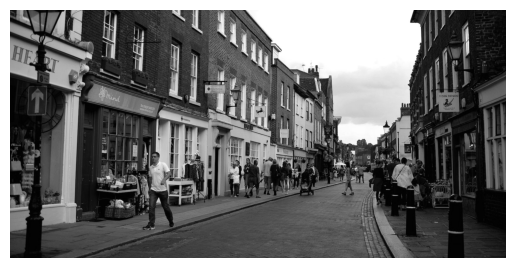

In [5]:
def convert_to_grayscale(path):
    """Конвертирует изображение в оттенки серого. """
    image = Image.open(path)  # Открываем изображение с использованием PIL (без url)
    image = np.asarray(image)  # Преобразуем изображение в массив numpy

    # Преобразование BGR в градации серого
    # Используем стандартные коэффициенты для преобразования цветного изображения в градации серого
    r, g, b = image[..., 2], image[..., 1], image[..., 0]  # Извлечение каналов (предполагается формат BGR)
    image = 0.2989 * r + 0.5870 * g + 0.1140 * b  # Преобразование в градации серого

    return image



image = convert_to_grayscale(PICTURE1_PATH)
Shower.show_img(image)


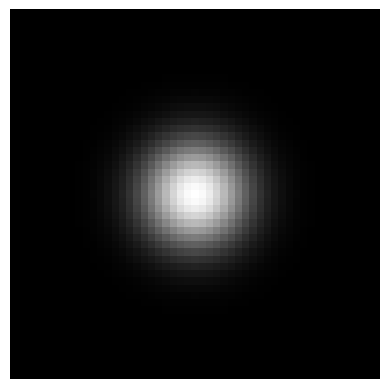

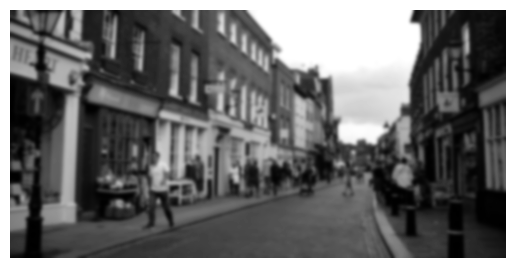

In [6]:
def filter_with_gaussian(image, is_print: bool = True):
    """Фильтрует изображение с использованием гауссовского фильтра. """
    # Создание ядра/фильтра (гауссовский фильтр)
    sigma = 5  # Параметр размытия
    filter_size = (50, 50)  # Размер фильтра (ширина, высота)
    size_y = filter_size[0] // 2  # Половина высоты фильтра
    size_x = filter_size[1] // 2  # Половина ширины фильтра

    # Создание сетки координат для ядра фильтра
    x, y = np.mgrid[-size_y:size_y+1, -size_x:size_x+1]  # Массивы координат x и y
    normal = 1 / (2.0 * np.pi * sigma**2)  # Нормализующий коэффициент
    gaussian_filter = np.exp(-((x**2 + y**2) / (2.0 * sigma**2))) * normal  # Формула для гауссовского фильтра

    # Применение свёртки (размытие изображения)
    filtered = ndimage.convolve(image, gaussian_filter)  # Свёртка изображения с гауссовским фильтром
    filtered = filtered.astype('uint8')  # Приведение к целочисленному типу для отображения

    # Отображение результатов
    plt.gray()  # Установка цветовой схемы для отображения в градациях серого

    # Визуализация гауссовского фильтра
    if is_print:
        Shower.show_img(gaussian_filter)
        Shower.show_img(filtered)

    return filtered



filtered = filter_with_gaussian(image)


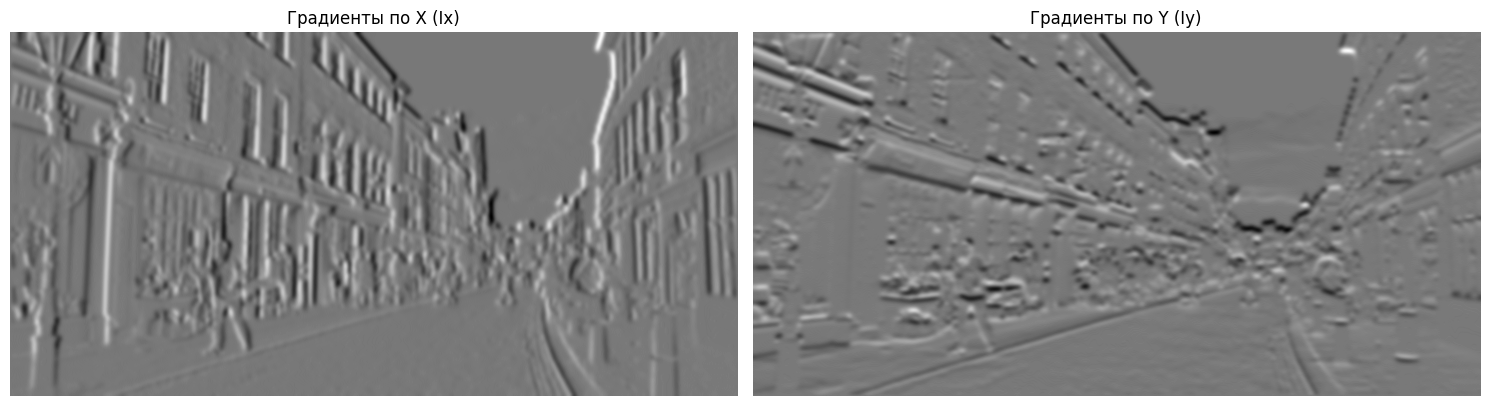

In [7]:
def calculate_sobel(filtered_image, is_print: bool = True):
    """Вычисление градиентов с использованием фильтров Собеля. """
    # Горизонтальный фильтр Собеля (Kx) для вычисления градиентов по оси X
    Kx = np.array(
        [[-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]], np.float32
    )

    # Вертикальный фильтр Собеля (Ky) для вычисления градиентов по оси Y
    Ky = np.array(
        [[1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]], np.float32
    )

    # Нормализация изображения (деление на 255 для перевода значений в диапазон 0-1)
    filtered_image = filtered_image / 255

    # Применение горизонтального фильтра (Kx) для получения градиентов по X
    Ix = ndimage.convolve(filtered_image, Kx)

    # Применение вертикального фильтра (Ky) для получения градиентов по Y
    Iy = ndimage.convolve(filtered_image, Ky)

    # Визуализация результатов
    if is_print:
        Shower.show_two_img(
            Ix, 
            Iy,
            title_img1 = "Градиенты по X (Ix)",
            title_img2 = "Градиенты по Y (Iy)",
            figsize=(15, 9)
        )

    return Ix, Iy



Ix, Iy = calculate_sobel(filtered)


<Figure size 1500x900 with 0 Axes>

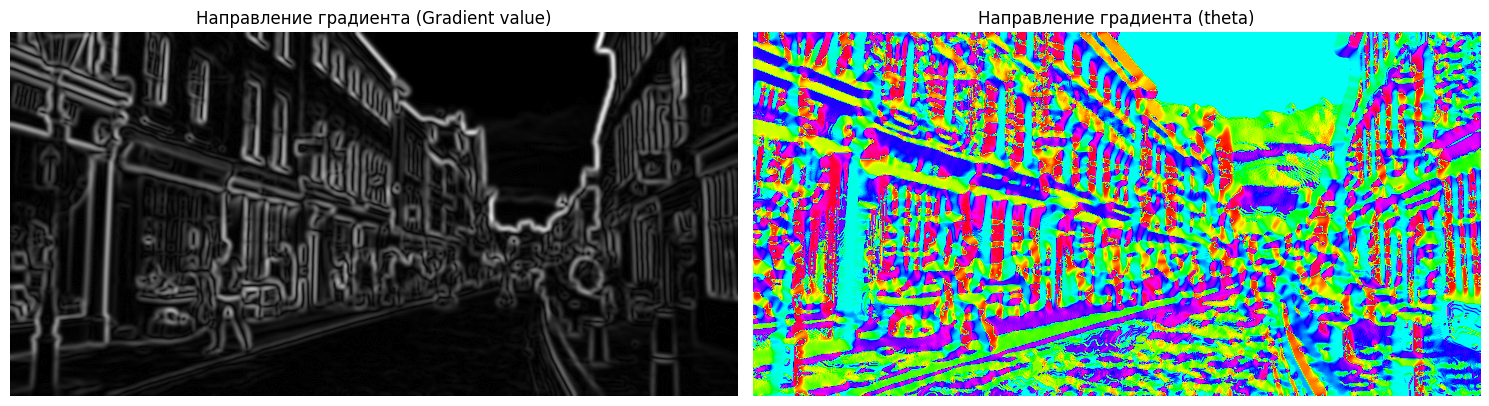

In [8]:
def calculate_gradient_values(Ix, Iy, is_print: bool = True):
    """Вычисление градиентной величины пикселей. """
    # Вычисление градиентной величины (G)
    # Метод 1: через квадратные корни суммы квадратов градиентов Ix и Iy
    # G = np.sqrt((Ix**2)+(Iy**2))
    '''или'''
    # Метод 2: используя np.hypot (эквивалентный расчету выше)
    Gradient = np.hypot(Ix, Iy)

    # Нормализация градиентной величины для отображения (в диапазоне от 0 до 255)
    Gradient = Gradient / Gradient.max() * 255

    # Вычисление направления градиента (theta) в радианах
    # np.arctan2 учитывает знаки Ix и Iy для определения полного направления
    theta = np.arctan2(Iy, Ix)

    # Визуализация результатов
    plt.figure(figsize=(15, 9))

    # Отображение карты градиентной величины (Gradient value) и (theta)
    if is_print:
        Shower.show_two_img(
            Gradient, 
            theta,
            title_img1 = 'Направление градиента (Gradient value)',
            title_img2 = 'Направление градиента (theta)',
            extra_img2_params = {'cmap': 'hsv'},
            figsize = (15, 9)
        )

    return Gradient, theta



gradient_value, theta = calculate_gradient_values(Ix, Iy)

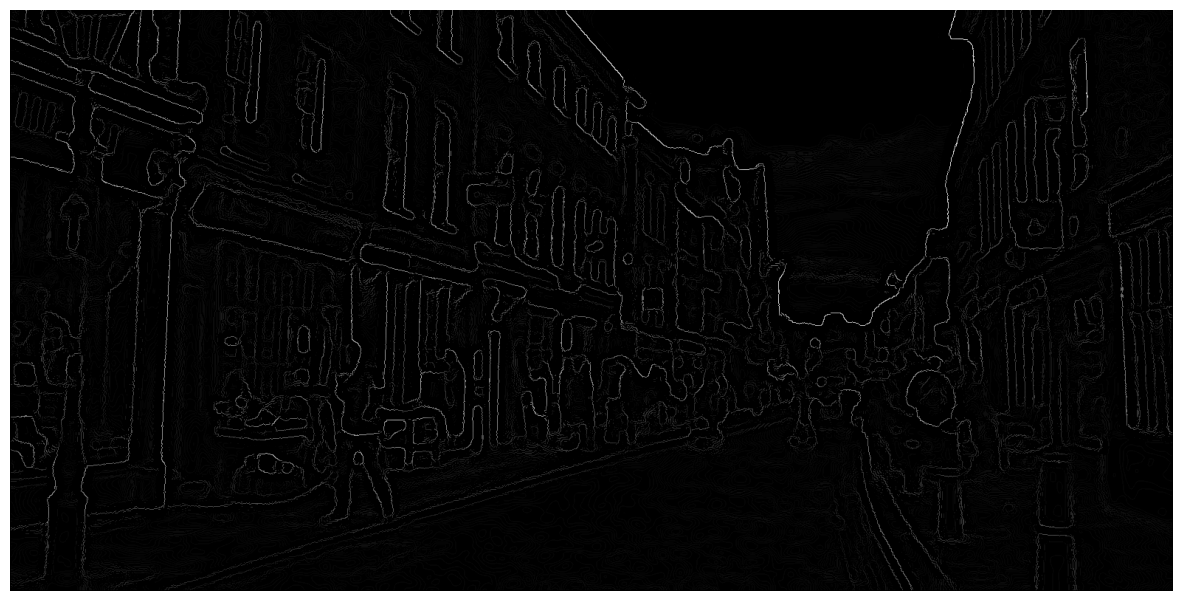

In [9]:
def non_max_suppression(gradient, theta, is_print: bool = True):
    """Подавление немаксимумов (Non Max Suppression). """
    # Размеры изображения
    M, N = gradient.shape

    # Создание массива для хранения результата
    result = np.zeros((M, N), dtype=np.int32)

    # Преобразование углов из радиан в градусы для удобства обработки
    angle = theta * 180. / np.pi    # Преобразование из радиан в градусы (диапазон: -180 до 180)
    angle[angle < 0] += 180         # Перевод диапазона в положительные значения (0 до 180)

    # Обход изображения (исключая границы)
    for i in range(1, M-1):
        for j in range(1, N-1):
            q = 255  # Инициализация значений q
            r = 255  # Инициализация значений r

            # Обработка направлений углов
            # Направление 0 градусов (горизонталь)
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                r = gradient[i, j-1]  # Сосед слева
                q = gradient[i, j+1]  # Сосед справа
            # Направление 45 градусов (диагональ вверх вправо)
            elif (22.5 <= angle[i, j] < 67.5):
                r = gradient[i-1, j+1]  # Сосед сверху справа
                q = gradient[i+1, j-1]  # Сосед снизу слева
            # Направление 90 градусов (вертикаль)
            elif (67.5 <= angle[i, j] < 112.5):
                r = gradient[i-1, j]  # Сосед сверху
                q = gradient[i+1, j]  # Сосед снизу
            # Направление 135 градусов (диагональ вверх влево)
            elif (112.5 <= angle[i, j] < 157.5):
                r = gradient[i+1, j+1]  # Сосед снизу справа
                q = gradient[i-1, j-1]  # Сосед сверху слева

            # Подавление немаксимумов
            if (gradient[i, j] >= q) and (gradient[i, j] >= r):  # Если текущая точка больше соседей
                result[i, j] = gradient[i, j]  # Сохраняем значение градиента
            else:
                result[i, j] = 0  # В противном случае присваиваем 0

    if is_print:
        Shower.show_img(result, in_gray=False, figsize=(15, 9))

    return result



surprassed = non_max_suppression(gradient_value, theta)

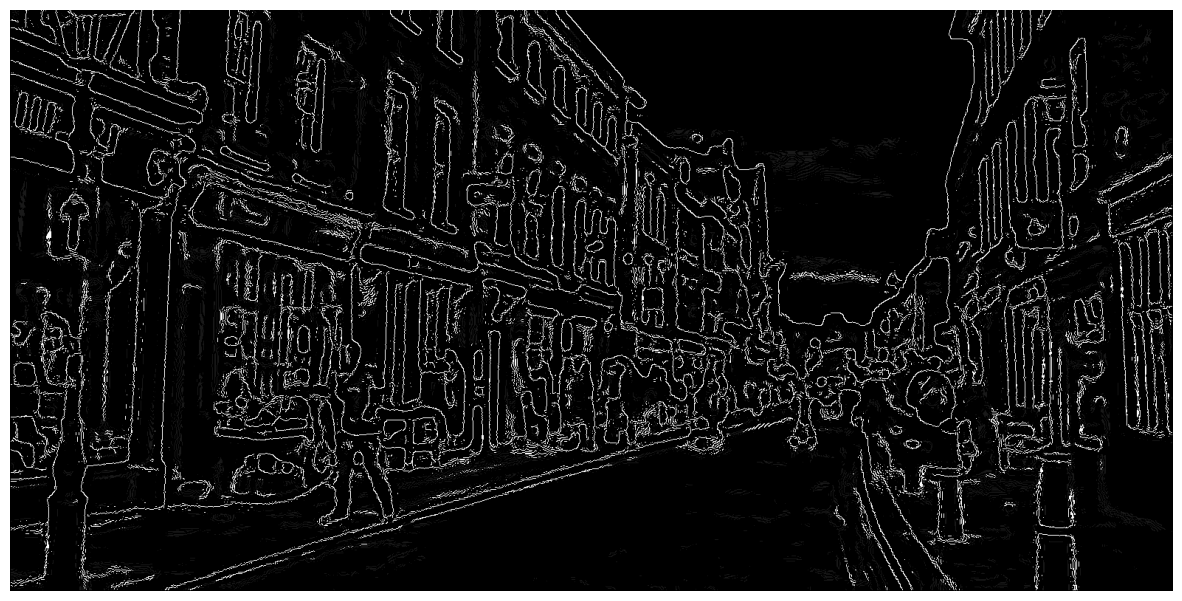

In [10]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09, is_print: bool = True):
    """Двойное пороговое преобразование (Double threshold). """
    # Вычисление порогов
    highThreshold = img.max() * highThresholdRatio  # Высокий порог (процент от максимального значения)
    lowThreshold = highThreshold * lowThresholdRatio  # Низкий порог (доля от высокого порога)

    # Размеры изображения
    M, N = img.shape

    # Инициализация результирующего изображения
    res = np.zeros((M, N), dtype=np.int32)

    # Определение значений для слабых и сильных границ
    weak = np.int32(25)  # Значение для слабых границ
    strong = np.int32(255)  # Значение для сильных границ

    # Нахождение координат пикселей:
    # Сильные границы (пиксели с интенсивностью >= highThreshold)
    strong_i, strong_j = np.where(img >= highThreshold)

    # Пиксели ниже низкого порога (порог отсева)
    zeros_i, zeros_j = np.where(img < lowThreshold)

    # Слабые границы (пиксели между низким и высоким порогами)
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    # Заполнение результирующего изображения
    res[strong_i, strong_j] = strong  # Сильные границы получают значение 255
    res[weak_i, weak_j] = weak  # Слабые границы получают значение 25

    if is_print:
        Shower.show_img(res, in_gray=False, figsize=(15, 9))
    
    # Возвращаем результирующее изображение и значения слабых/сильных границ
    return (res, weak, strong)



thresholded = threshold(surprassed, 0.5)[0]

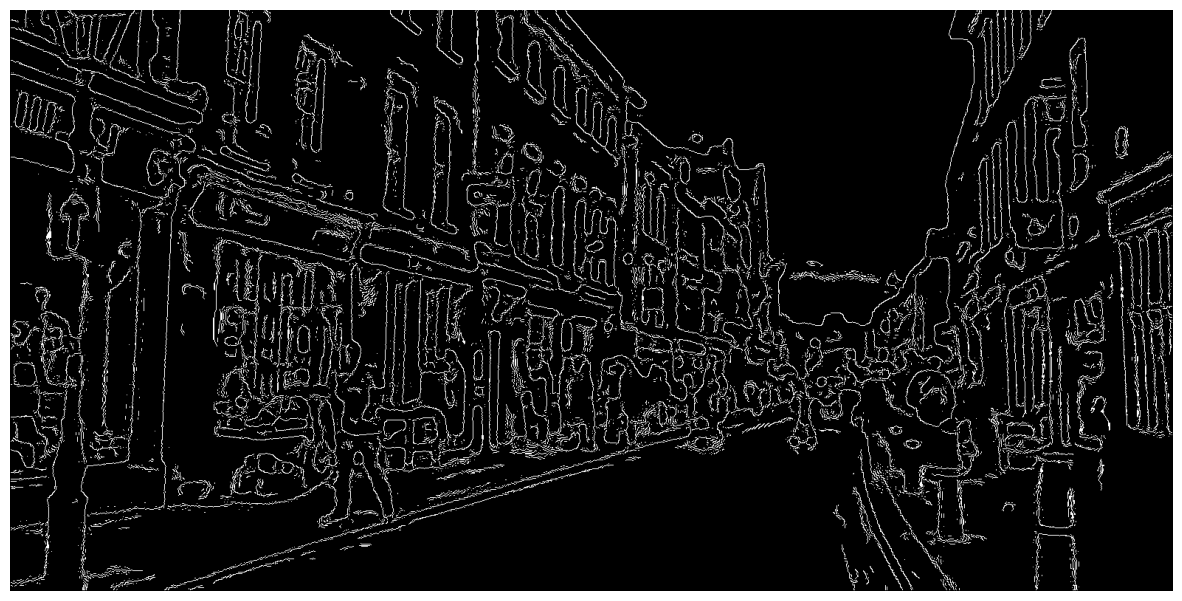

In [11]:
def hysteresis(img, weak, strong=255, is_print: bool = True):
    """Гистерезисное отслеживание (Hysteresis Edge Tracking). """
    # Размеры изображения
    M, N = img.shape

    # Проход по изображению (исключаем границы, так как они не обрабатываются)
    for i in range(1, M-1):
        for j in range(1, N-1):
            # Если текущий пиксель — слабая граница
            if (img[i, j] == weak):
                # Проверяем, связана ли слабая граница с сильной (в 8-связной окрестности)
                if (
                    (img[i+1, j-1] == strong) or (img[i+1, j] == strong) or
                    (img[i+1, j+1] == strong) or (img[i, j-1] == strong) or
                    (img[i, j+1] == strong) or (img[i-1, j-1] == strong) or
                    (img[i-1, j] == strong) or (img[i-1, j+1] == strong)
                ):
                    img[i, j] = strong  # Превращаем слабую границу в сильную
                else:
                    img[i, j] = 0  # Удаляем слабую границу (не связана с сильной)

    if is_print:
        Shower.show_img(img, in_gray=False, figsize=(15, 9))

    # Возвращаем обработанное изображение
    return img



final_image = hysteresis(thresholded,25)

 Таким образом, cверху определен основные функции для получения и детектирования границ канни

In [12]:
final_image.shape

(788, 1576)

 # ДЗ: Последовательное использование методов детектирования границ



 Сбор описанных выше методов в одну функцию, которая на вход принимает путь к изображению и возвращает финальный результат.

In [13]:
def boundaries_detection(filepath: str):
    # Конвертация в оттенки серого
    image = convert_to_grayscale(filepath)

    # Фильтрация через гауссовский фильтр
    filtered = filter_with_gaussian(image, is_print=False)

    # Вычисление градиентов с помощью операторов Собеля
    Ix, Iy = calculate_sobel(filtered, is_print=False)

    # Вычисление градиентной величины пикселей
    gradient_value, theta = calculate_gradient_values(Ix, Iy, is_print=False)

    # non-max подавление слабых величин
    surprassed = non_max_suppression(gradient_value, theta, is_print=False)

    # Удаление слабых границ двойным пороговым преобразованием
    thresholded = threshold(surprassed, 0.5, is_print=False)[0]

    # Получение финальных сдетектированных границ
    final_image = hysteresis(thresholded,25, is_print=False)

    return final_image


 ## Картинка1: размытое фото авто

[Комментарий студента] Не нашла, где лежит нужное фото. Скачала другую размытую машину

<Figure size 640x480 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

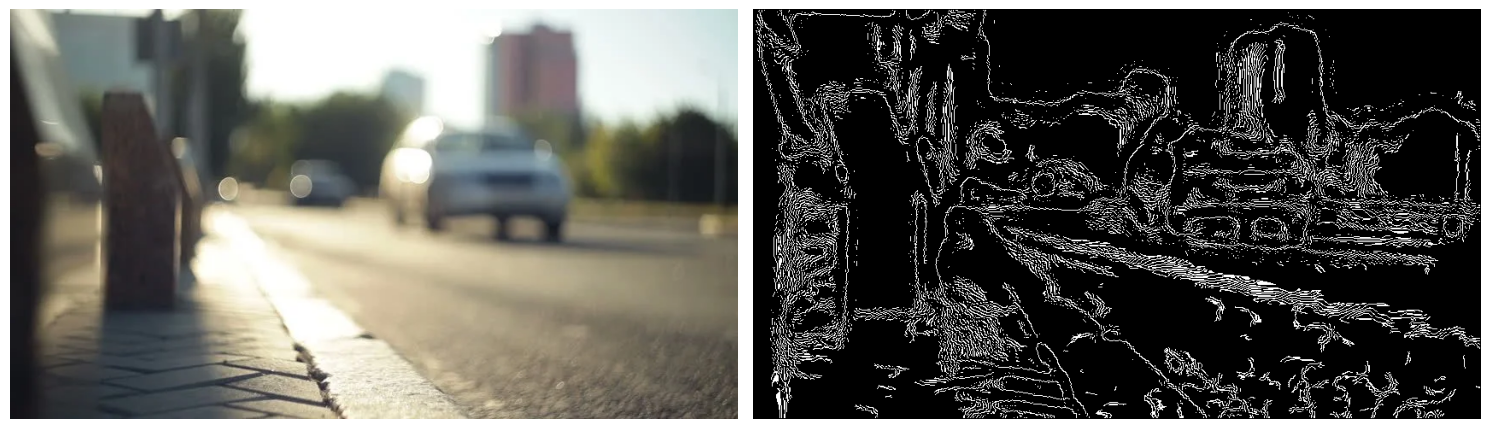

In [14]:
PICTURE2_PATH = PICTURES_PATH + 'practica_5(3).webp'

target_img = cv2.cvtColor(cv2.imread(PICTURE2_PATH), cv2.COLOR_BGR2RGB)
img1 = boundaries_detection(PICTURE2_PATH)

Shower.show_two_img(target_img, img1, figsize = (15, 9))


 ## Картинка2: фото стадиона

<Figure size 640x480 with 0 Axes>

<Figure size 1500x900 with 0 Axes>

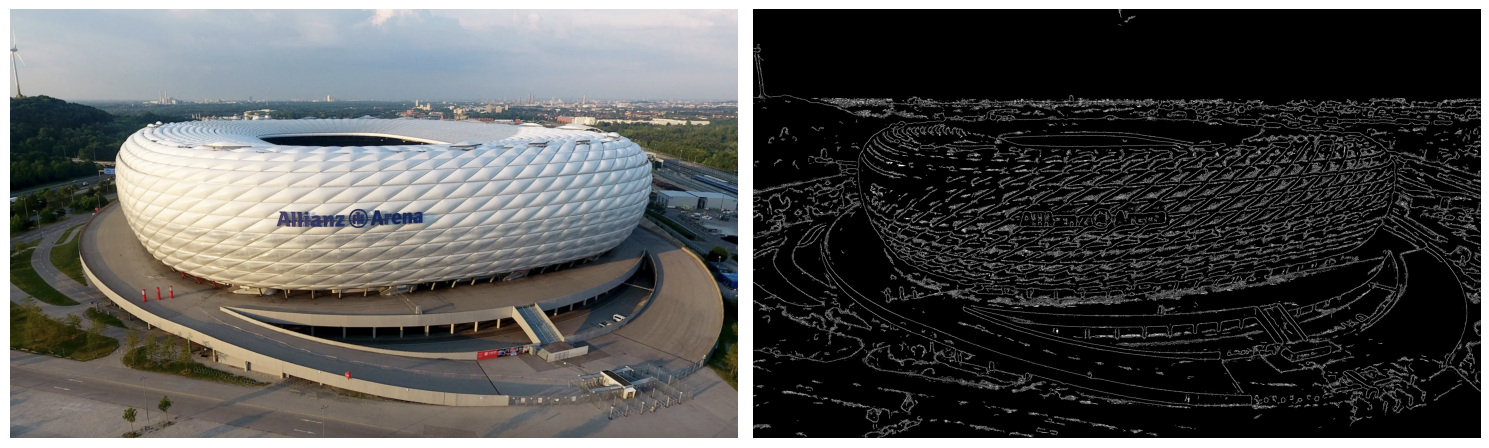

In [15]:
PICTURE3_PATH = PICTURES_PATH + 'practica_5(2).jpg'

target_img = cv2.cvtColor(cv2.imread(PICTURE3_PATH), cv2.COLOR_BGR2RGB)
img2 = boundaries_detection(PICTURE3_PATH)

Shower.show_two_img(target_img, img2, figsize = (15, 9))